# In Depth: Manifold Learning
While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data. To address this deficiency, we can turn to a class of methods known as ***manifold learning***. Manifold learning is a class of unsupervised estimators that seeks to describe datasets as low dimensional manifolds embedded in high-dimensional spaces. Imagine a sheet of paper: this is a two-dimensional object that lives in our three-dimensional world, and can be bent or rolled in two dimensions. We can think of this sheet of paper as a two-dimensional manifold embedded in three-dimensional space.

Rotating, reorienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper, which is similar to linear embeddings. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. Manifold learning algorithms seek to learn the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learning: "HELLO"
Let's start by generating some two-dimensional data that we can use to define a manifold.

In [2]:
def make_hello(N=1000, rseed=42):
    """ Make a plot with "HELLO" text; save as PNG"""
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

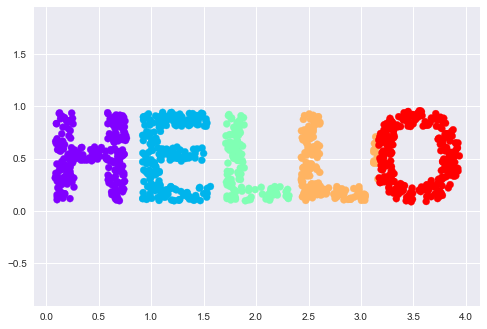

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## Multidimensional Scaling (MDS)
Looking at data like this, we can see that the particular choice of x and y values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.

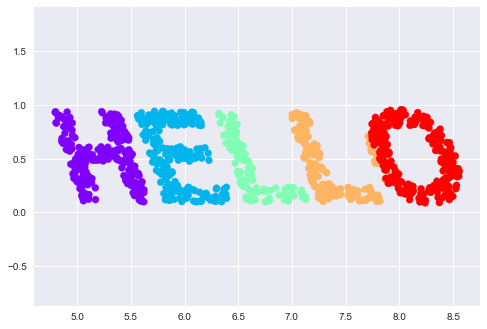

In [6]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X[:, 1], **colorize)
plt.axis('equal');

This tells us that the x and y values are not necessarily fundamental to the relationshops in the data. What is fundamental, in this case, is the distance between each point and the other points in the dataset. A common way to represent this is to use a distance matrix: for N points, we construct an NxN array such that entry (i,j) contains the distance between point i and point j.

In [8]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

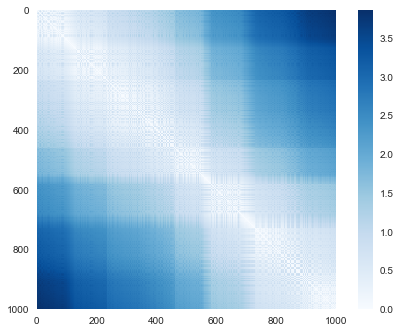

In [9]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [10]:
# Construct distance matrix for rotated and translated data
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

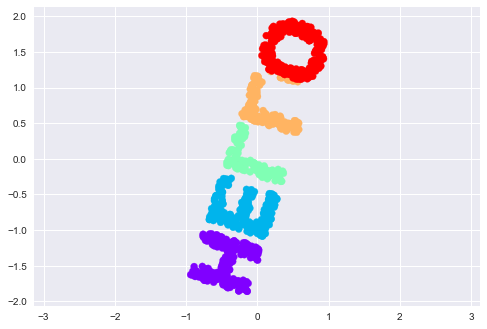

In [11]:
# transform distances back into X & Y coordinates
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using only the NxN distance matrix describing the relationship between the data points.

## MDS as Manifold Learning
Distance matrices can actually be computed from data in any dimension. So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function:

In [12]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

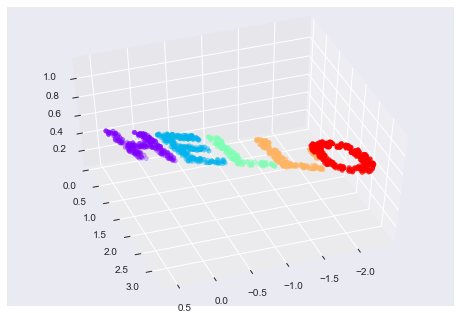

In [13]:
# visualize points
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(X3[:,0], X3[:,1], X3[:,2], **colorize)
ax.view_init(azim=70, elev=50)

Now ask the MDS estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix. The result should recover a representation of the original data:

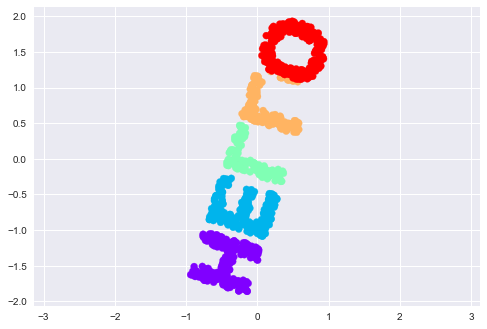

In [14]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is essentially the goal of a manifold learning estimator: **given high-dimensional embedded data, it sees a low-dimensional representation of the data that preserves certain relationships within the data.** In the case of MDS, the quantity preserved is the distance between every pair of points.

## Nonlinear Embeddings: Where MDS Fails
Where MDS breaks down is when the embedding is nonlinear- that is, when it goes beyond this simple set of operations. Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [19]:
def make_hello_s_curve(X):
    t = (X[:,0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

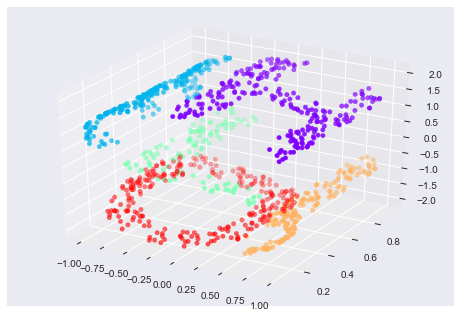

In [20]:
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:,0], XS[:,1], XS[:,2], **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped up into the shape of an "S".

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

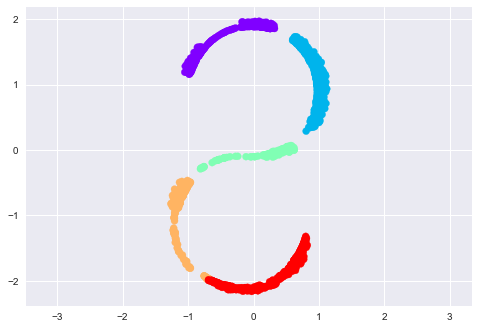

In [21]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:,0], outS[:,1], **colorize)
plt.axis('equal');

The best two-dimensional linear embedding does not unwrap the S-curve, but instead throws out the original y-axis.

## Nonlinear Manifolds: Locally Linear Embedding
The source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding. But wwhat if we instead modified the algorithm such that it only preserves distances between nearby points? The resulting embedding would be closer to what we want.

![llevsmds](images/LLEvsMDS.png)

In the image above, each faint line represents a distance that should be preserved in the embedding. MDS (left) tries to preserve the distances between each pair of points in the dataset. On the right is a representation of the model used by a manifold learning algorithm called ***locally linear embedding (LLE)***: rather than preserving all distances, it instead tries to preserve only the distances between neighboring points: in this case, the nearest 100 neighbors of each point.

In general, modified LLE does better than other variations of the LLE algorithm at recovering well-defined manifolds with very little distortion.

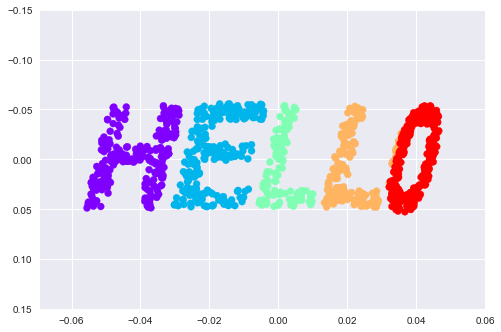

In [24]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

## Some Thoughts on Manifold Methods
In practice, manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:
 - In manifold learning, there is no good framework for handling missing data. In PCA, there are straightforward iterative approaches for missing data.
 - In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. PCA naturally filters noise from the most important components.
 - The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. PCA does not involve such a choice.
 - In manifold learning, the globally optimal number of output dimensions is difficult to determine. PCA lets you find the output dimension based on the explained variance.
 - In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
 - In manifold learning, the computational expense of manifold methods scales as O[$N^2$] or O[$N^3$]. For PCA, there exist randomized approaches that are generally much faster.
 
The only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data. It is common practice to explore data with manifold methods only after first exploring it with PCA.

## Example: Isomap on Faces
One place manifold learning is often used is in understanding the relationship between high-dimensional data points. A common case of high-dimensional data is images. For example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions.

Here let's apply Isomap on some faces data.

In [25]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person = 30)
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels - or data points in a 2,914-dimensional space!

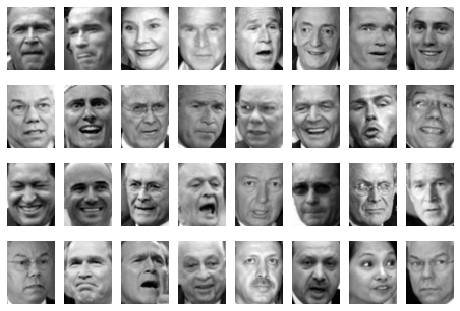

In [26]:
# visualize images
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images. A useful way to start is to compute a PCA, and examine the explained variance ratio, which will give an idea of how many linear features are required to describe the data:

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


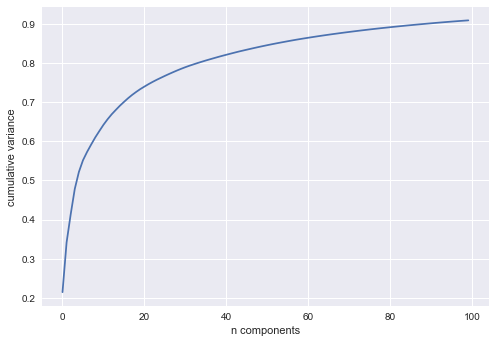

In [27]:
from sklearn.decomposition import RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

It appears that nearly 100 components are needed to preserve 90% of the variance. This tells us that our data is intrinsically very high dimensional and can't be described linearly with just a few components. When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful.

In [28]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [29]:
# output is a two-dimensional projection of input images
# define a function to output thumbnails at locations of projections
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:,0], proj[:,1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)

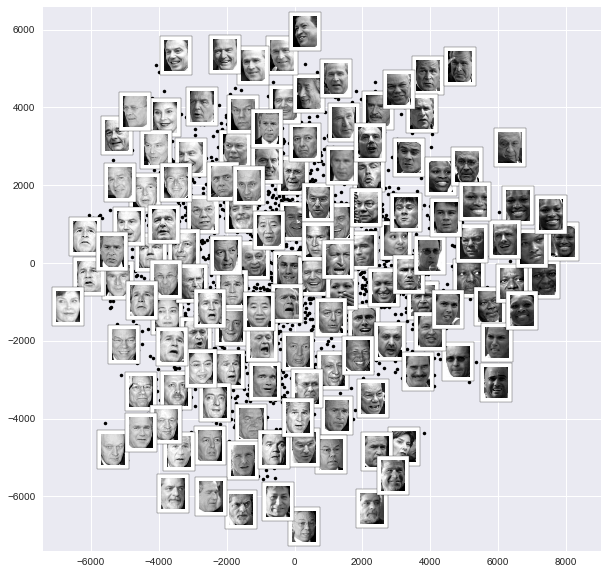

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image shown from left to right, and the general orientation of the face from bottom to top.

We could go on to classify this data, perhaps using manifold features as inputs to a classification algorithm like SVM.

## Example Visualizing Structure in Digits
As another example of using manifold learning, let's take a look at the MNIST handwritten digits set.

In [39]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

This consists of 70,000 images, each with 784 pixels.

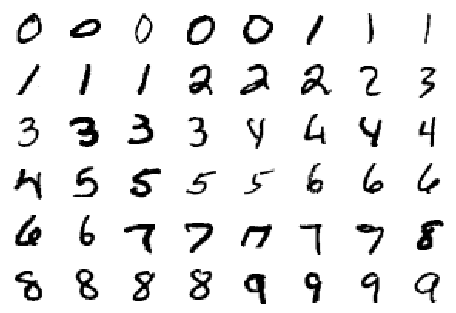

In [40]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

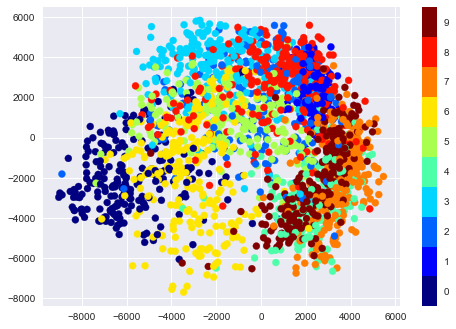

In [41]:
# use only 1/30 of the data: full dataset takes a long time
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

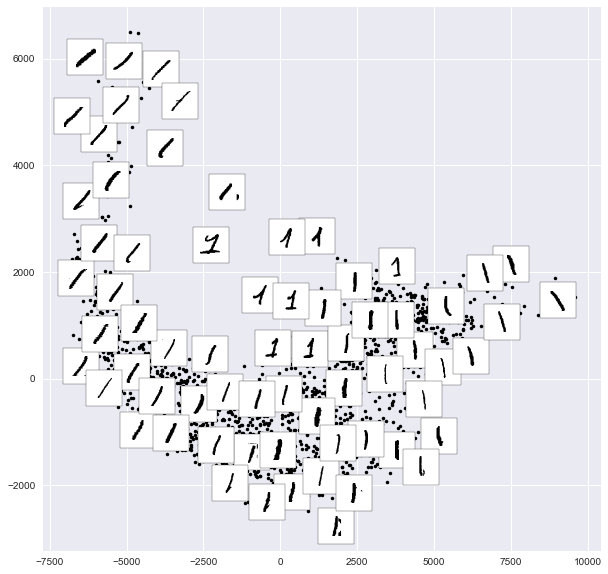

In [42]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)), ax=ax, thumb_frac=0.05,
                cmap='gray_r')

The result above gives us an idea of the variety of the forms that the number "1" can take within the dataset. 